<a href="https://colab.research.google.com/github/ItsTSV/DeepLearning/blob/main/rnn_review_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Projekt -- Trip Advisor Hotel Reviews

## Tomáš Svoboda, SVO0280

Jakožto svůj RNN projekt jsem si vybral predikci hodnocení hotelů na základě recenzí na TripAdvisoru. Jedná se o dataset
Trip Advisor Hotel Reviews z Kaggle (https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews). V první části
provedu základní explorační analýzu dat a preprocessing, ve druhé pak vyzkouším a porovnám vlastní a již existující
dotrénované modely.


### I. Základní explorační analýza

In [108]:
!pip install attention

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata, re, string
import nltk
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_absolute_error
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import normalize
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
from attention import Attention
import tensorflow_hub as hub
import tensorflow_text as text
import keras_nlp

In [110]:
# Read the data, get some basic info
df = pd.read_csv("tripadvisor_hotel_reviews.csv")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [111]:
df.nunique()

,0
Review,20491
Rating,5


In [112]:
df.isna().sum()

,0
Review,0
Rating,0


Dataset je poměrně jednoduchý. Obsahuje dva sloupce: text recenze a číselné hodnocení (hvězdičky). Všechny texty jsou unikátní, číselná hodnocení se pak pohybují v rozsahu 1 až 5 hvězd. Dataset je navíc kompletní, neobsahuje žádné null hodnoty.

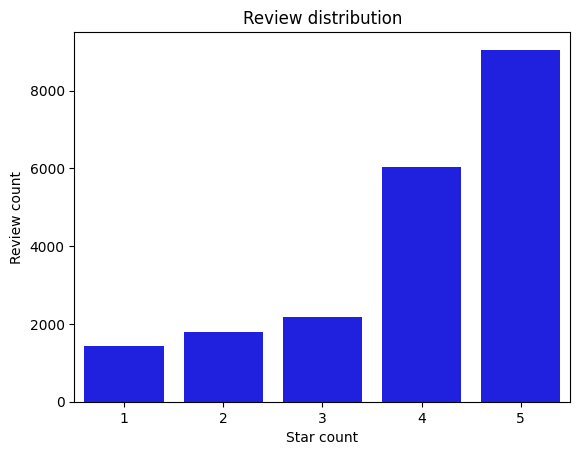

In [113]:
# Review distribution
(sns.countplot(data=df, x="Rating", color="blue").set(title="Review distribution",
                                                      xlabel="Star count",
                                                      ylabel="Review count"))
plt.show()

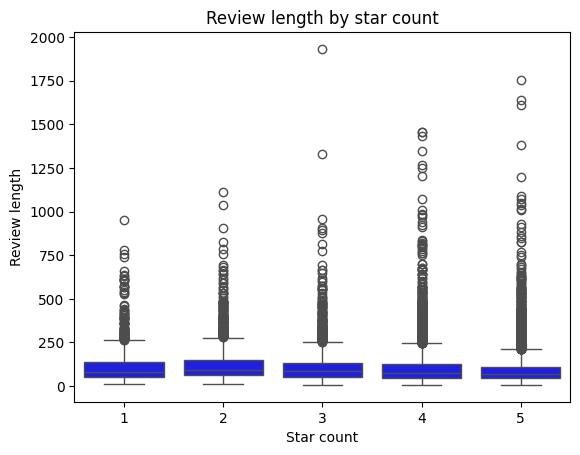

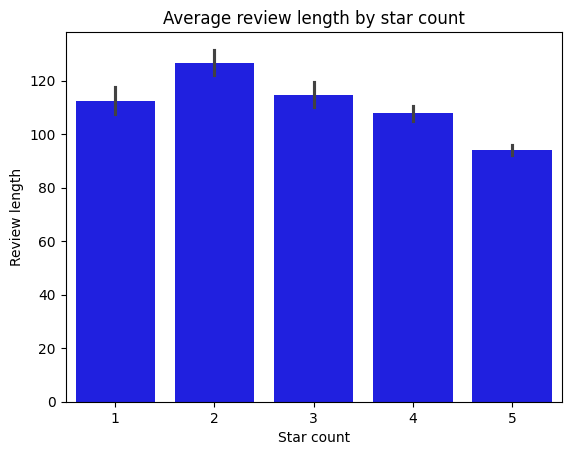

In [114]:
# Review length distribution by rating
df_tmp = df.copy()
df_tmp["ReviewLength"] = df["Review"].apply(lambda x: len(x.split()))

(sns.boxplot(data=df_tmp, x="Rating", y="ReviewLength", color="blue").set(title="Review length by star count",
                                                                      xlabel="Star count",
                                                                      ylabel="Review length"))
plt.show()

(sns.barplot(data=df_tmp, x="Rating", y="ReviewLength", color="blue").set(title="Average review length by star count",
                                                                       xlabel="Star count",
                                                                       ylabel="Review length"))
plt.show()


Examples of reviews with 1 stars
15    horrible customer service hotel stay february ...
32    noise airconditioner-a standard, arranged stay...
40    bad choice, booked hotel hot wire called immed...
65    hated inn terrible, room-service horrible staf...
69    ace grunge lives does mold mildew tiny bed met...


Examples of reviews with 2 stars
1     ok nothing special charge diamond member hilto...
10    poor value stayed monaco seattle july, nice ho...
16    disappointed say anticipating stay hotel monac...
24    great location need internally upgrade advanta...
33    good location poor cleanliness warwick hotel g...


Examples of reviews with 3 stars
2     nice rooms not 4* experience hotel monaco seat...
13    nice hotel not nice staff hotel lovely staff q...
19    hmmmmm say really high hopes hotel monaco chos...
25    n't mind noise place great, read reviews noise...
27    met expectations centrally located hotel block...


Examples of reviews with 4 stars
0     nice hotel expen

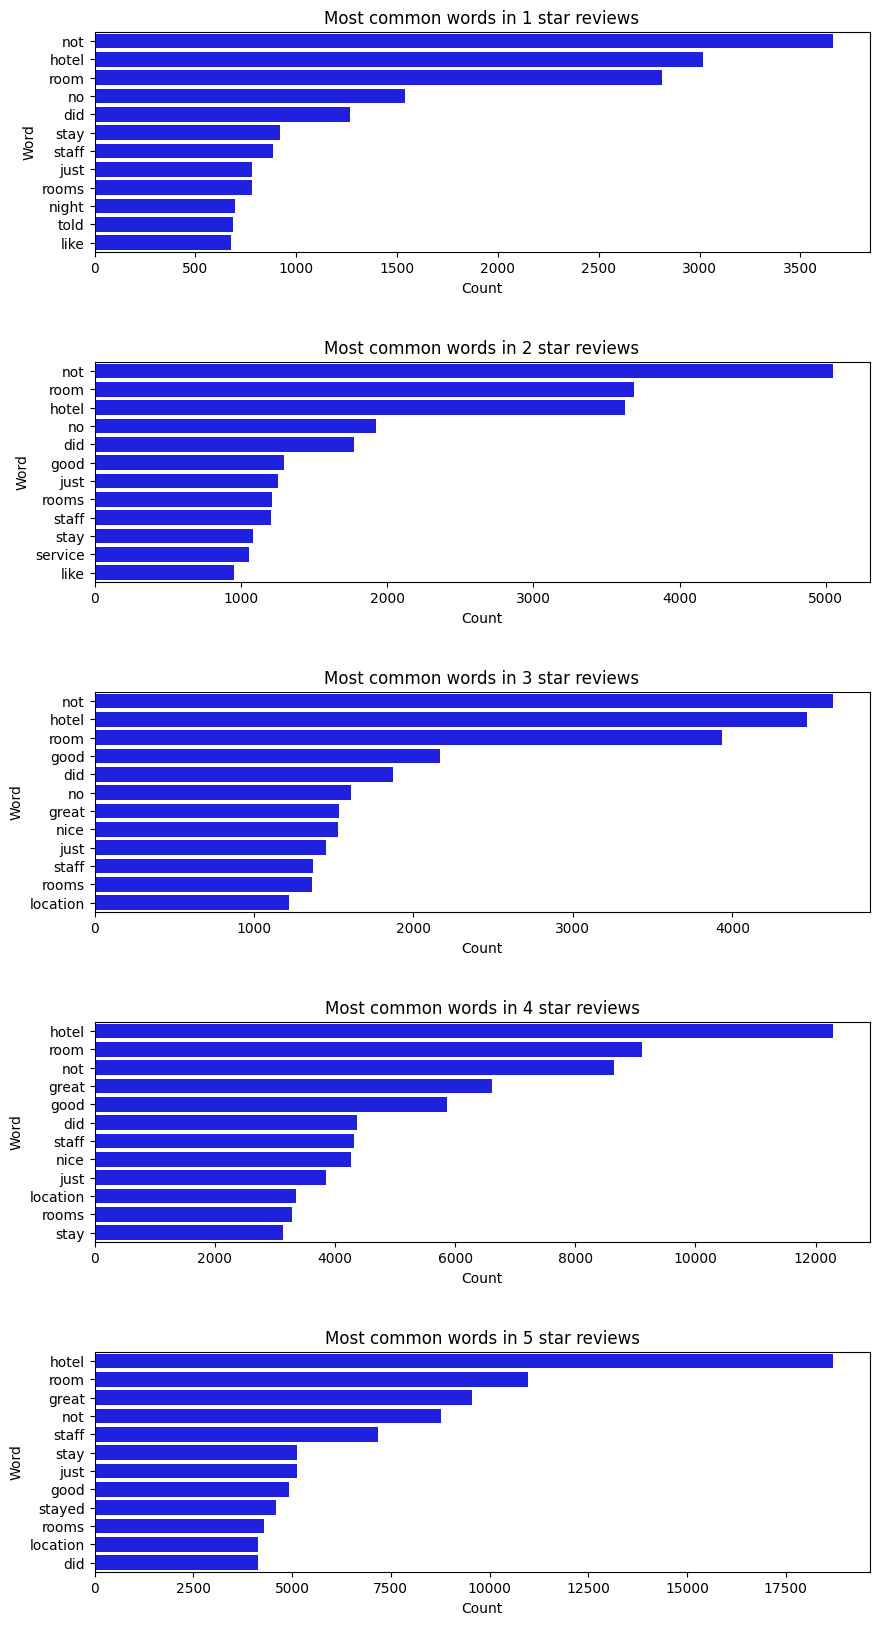

In [115]:
def rating_info():
    fig, axs = plt.subplots(5, 1, figsize=(10, 20))
    fig.subplots_adjust(hspace=0.5)

    for i in range(1, 6):
        df_tmp = df[df["Rating"] == i]
        print(f"Examples of reviews with {i} stars")
        print(df_tmp["Review"].head().to_string())
        print("\n")

        all_reviews = " ".join(df_tmp["Review"])
        all_reviews = all_reviews.lower()
        all_reviews = all_reviews.split()
        all_reviews = [word for word in all_reviews if word != "n't"]
        all_reviews = pd.Series(all_reviews)
        all_reviews = all_reviews.value_counts().sort_values(ascending=False).head(12)
        sns.barplot(x=all_reviews.values, y=all_reviews.index, ax=axs[i-1], color="blue")
        axs[i-1].set_title(f"Most common words in {i} star reviews")
        axs[i-1].set_xlabel("Count")
        axs[i-1].set_ylabel("Word")


rating_info()

Po bližším prozkoumání datasetu lze vidět, že data nejsou vyvážená -- velmi dobrá hodnocení převažují (4 a 5), kdežto ta průměrná a špatná (1, 2, 3) nejsou až tak zastoupena. Průměrné délky recenzí se liší (obecně platí: negativní recenze -> delší, pozitivní recenze -> kratší). Též se zde nachází velké množství outlierů-grafomanů -- ti budou z datasetu odstraněni. Nejčastěji zastoupená slova v recenzích jsou dost podobná; v dobrých hodnoceních se však více objevují pozitivní slova jako "great", "good", kdežto ve špatných hodnoceních je jich méně -- očekávané.

### II. Preprocessing

Při preprocessingu bude potřeba dostat recenze do jednotné, poměrně srozumitelné podoby. Texty recenzí by měly být:

- bez speciálních znaků,
- lowercase,
- bez stopwordů,
- bez interpunkčních znamének.

Čísla pravděpodobně zachovat chtít budeme, jelikož dost napoví o výsledném hodnocení.
Dále bude potřeba pracovat jen s kořeny slov (lemmatizace). Výsledné texty by pak měly být podstatně srozumitelnější -- alespoň pro neuronové sítě ;)



In [116]:
!python -m textblob.download_corpora
nltk.download("stopwords")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [117]:
# Taken from Notebook #6
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in nltk.corpus.stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    stemmer = nltk.LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    lemmatizer = nltk.WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = replace_nts(words)
    return words

def replace_nts(words):
    new_words = []
    for word in words:
        if word == "nt":
            new_words.append("not")
        else:
            new_words.append(word)
    return new_words

def form_sentence(review):
    review_blob = TextBlob(review)
    return review_blob.words

In [118]:
# Normalization
df["Words"] = df["Review"].apply(form_sentence)
df["Words_normalized"] = df["Words"].apply(normalize)

In [119]:
# Join back to sentences, drop tmp columns and original review column
df["Clean_Review"] = df['Words_normalized'].apply(lambda x: ' '.join(x))
df.drop(columns=["Words", "Words_normalized"], inplace=True)

In [120]:
# Drop all reviews that are longer than 210
df = df[df["Clean_Review"].apply(lambda x: len(x.split()) < 210)]
df.shape

(18742, 3)

Pro použití Sparse Categorical Crossentropy loss funkce je potřeba upravit hodnocení, ať se nacházejí v rozsahu [0,1,2,3,4], ne [1,2,3,4,5].


In [121]:
df["Rating"] = df["Rating"] - 1

<ipython-input-121-2f0137bdfe9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"] = df["Rating"] - 1


In [122]:
df.head()

,Review,Rating,Clean_Review
0,nice hotel expensive parking got good deal sta...,3,nice hotel expensive parking got good deal sta...
3,"unique, great stay, wonderful time hotel monac...",4,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",4,great stay great stay went seahawk game awesom...
5,love monaco staff husband stayed hotel crazy w...,4,love monaco staff husband stayed hotel crazy w...
6,"cozy stay rainy city, husband spent 7 nights m...",4,cozy stay rainy city husband spent 7 nights mo...


Texty by nyní měly být vyčištěny a připraveny pro další zpracování. Nyní už je jen rozdělím na trénovací a testovací sadu. Jelikož není dataset vyvážený, použiju stratify sampling.

In [123]:
X_train, X_test, y_train, y_test = train_test_split(df.Clean_Review, df.Rating, test_size=0.2, random_state=420, stratify=df.Rating)

In [124]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=420,stratify=y_train)

### III. Vlastní model

V dalším kroku si zkusím vytvořit vlastní model pro odhadování výsledného hodnocení na základě textu recenze. Pro optimalizaci modelu použiju AdamW, jelikož se jedná o slušnou "default" volbu, která není příliš citlivá na hyperparametry. Pro rozhodování mezi více labely použiju Sparse Categorial Crossentropy.

Pro vyhodnocení modelu použiju dvě metriky:

- Mean Absolute Error proto, že by bylo vhodné vědět nejen to, jestli se model zmýlil, ale i to, **o kolik** se zmýlil.
- Accuracy jakožto tu nejjednodušší metriku vyhodnocování správnosti.

In [125]:
embedding_dim = 150
vocab_size = 15000
sequence_length = 45

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Clean_Review.values)

Poznámka: TensorFlow metriky používaly deprecated knihovny a vyhazovaly množství random errorů, proto v model.compile() použiju jen Accuracy a F1 a MAE dopočítám až při testování modelu pomocí Sklearn.

In [155]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = LSTM(128, activation='relu', return_sequences=True)(emb)
x = keras.layers.Attention(use_scale=True)([x, x])
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 45)        │          0 │ input_layer_7[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 45, 200)   │  3,000,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 45, 128)   │    168,448 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_7         │ (None, 45, 128)   │          1 │ lstm_7[0][0],     │
│ (Attention)         │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_7[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │      8,256 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 32)        │      2,080 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_157         │ (None, 32)        │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 5)         │        165 │ dropout_157[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,195,462 (12.19 MB)

 Trainable params: 3,195,462 (12.19 MB)

 Non-trainable params: 0 (0.00 B)

In [156]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [158]:
batch_size = 128
epochs = 20


history = model.fit(X_train.values, tf.cast(y_train.values, tf.int32),
                    validation_data=(X_val.values, tf.cast(y_val.values, tf.int32)),
                    callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.4206 - loss: 1.3080 - val_accuracy: 0.5377 - val_loss: 1.0231
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.5638 - loss: 0.9559 - val_accuracy: 0.5630 - val_loss: 0.9898
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.6534 - loss: 0.7941 - val_accuracy: 0.5788 - val_loss: 1.0316
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7183 - loss: 0.6676 - val_accuracy: 0.5730 - val_loss: 1.0951
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.7918 - loss: 0.5408 - val_accuracy: 0.5654 - val_loss: 1.2129
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.8490 - loss: 0.4313 - val_accuracy: 0.5575 - val_loss: 1.3745
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.8697 - loss: 0.3733 - val_accuracy: 0.5413 - val_loss: 1.6808
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.9058 - loss: 0.28

In [159]:
model.load_weights("best.weights.h5")

In [160]:
y_pred = model.predict(X_val.values)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_val.values, y_pred_labels)
f1 = f1_score(y_val.values, y_pred_labels, average='weighted')
mae = mean_absolute_error(y_val.values, y_pred_labels)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"MAE: {mae}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Accuracy: 0.5629765172308631
F1 Score: 0.5525480403986954
MAE: 0.5434583714547118


Pro trochu názornější a interaktivnější ukázku jsem si napsal pár vlastních hodnocení, které zkusím vyhodnotit pomocí modelu.

In [131]:
sample_reviews = [
    "avoid place worst stay ever dirty room rude front desk disgusting bathroom",                       # 1 star
    "not great okay at best hotel old furniture slow check-in small uncomfortable bed",                 # 2 star
    "average experience location good room outdated ok for quick stay nothing wow",                     # 3 star
    "pleasant surprise friendly staff clean room bit noisy but overall enjoyed stay",                   # 4 star
    "amazing stay beautiful room great service perfect location definitely recommend"                   # 5 star
]


for review in sample_reviews:
    input_tensor = tf.constant([review], dtype=tf.string)
    prediction = model.predict(input_tensor)
    predicted_star = tf.argmax(prediction, axis=1).numpy()[0] + 1
    print(f"Review: {review}\nPredicted stars: {predicted_star} ⭐\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Review: avoid place worst stay ever dirty room rude front desk disgusting bathroom
Predicted stars: 1 ⭐

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Review: not great okay at best hotel old furniture slow check-in small uncomfortable bed
Predicted stars: 3 ⭐

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Review: average experience location good room outdated ok for quick stay nothing wow
Predicted stars: 3 ⭐

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Review: pleasant surprise friendly staff clean room bit noisy but overall enjoyed stay
Predicted stars: 4 ⭐

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Review: amazing stay beautiful room great service perfect location definitely recommend
Predicted stars: 5 ⭐



Výsledná přesnost modelu je 56.3%. Model se pak průměrně mýlí o půl hvězdičky (MAE = 0.543). Taková čísla se sice ani zdaleka neblíží state of the art modelům, avšak vzhledem k jednoduchosti a době trénování vlastního modelu to není zlé.


### IV. Použití GloVe
Nyní použiju již předtrénovaný embedding. Očekávám, že výsledky modelu se zlepší, avšak zlepšení to nebude nikterak velké. Metriky použiji stejné jako v případě vlastního modelu; pozměním pouze některé hyperparametry.



In [132]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-05-08 14:39:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-08 14:39:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-08 14:39:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [133]:
path_to_glove_file = 'glove.6B.200d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [134]:
embedding_dim = 200
vocab_size = 15000
sequence_length = 45

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Clean_Review.values)

voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [135]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 13044 words (1956 misses)


In [136]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = Bidirectional(LSTM(128, return_sequences=True))(emb)
x = keras.layers.Attention(use_scale=True)([x, x])
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 45)        │          0 │ input_layer_5[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 45, 200)   │  3,000,400 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 45, 256)   │    336,896 │ embedding_5[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_5         │ (None, 45, 256)   │          1 │ bidirectional_3[… │
│ (Attention)         │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention_5[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      8,256 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      2,080 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_149         │ (None, 32)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 5)         │        165 │ dropout_149[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,380,694 (12.90 MB)

 Trainable params: 380,294 (1.45 MB)

 Non-trainable params: 3,000,400 (11.45 MB)

In [137]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.glove.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [138]:
batch_size = 128
epochs = 20


history = model.fit(X_train.values, tf.cast(y_train.values, tf.int32),
                    validation_data=(X_val.values, tf.cast(y_val.values, tf.int32)),
                    callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4485 - loss: 1.2983 - val_accuracy: 0.5752 - val_loss: 0.9861
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5541 - loss: 0.9909 - val_accuracy: 0.5995 - val_loss: 0.9530
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5953 - loss: 0.9273 - val_accuracy: 0.6215 - val_loss: 0.8939
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6166 - loss: 0.8770 - val_accuracy: 0.6189 - val_loss: 0.8848
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6316 - loss: 0.8411 - val_accuracy: 0.6252 - val_loss: 0.8850
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6481 - loss: 0.8021 - val_accuracy: 0.6249 - val_loss: 0.8655
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6601 - loss: 0.7829 - val_accuracy: 0.6262 - val_loss: 0.8616
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6690 - loss: 0.7492 - val_accuracy: 0.6202 - v

In [139]:
model.load_weights("best.glove.weights.h5")

In [140]:
y_pred = model.predict(X_val.values)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_val.values, y_pred_labels)
f1 = f1_score(y_val.values, y_pred_labels, average='weighted')
mae = mean_absolute_error(y_val.values, y_pred_labels)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"MAE: {mae}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.6262087362454152
F1 Score: 0.6217655440177454
MAE: 0.45448482827609205


In [150]:
sample_reviews = [
    "horrible hotel broken ac bugs in bed terrible smell staff unhelpful never again",                  # 1 star
    "meh experience weak wifi poor breakfast noisy hallway decent staff but not worth price",           # 2 star
    "decent stay clean enough average service location was okay nothing special",                       # 3 star
    "very good hotel comfy bed helpful staff minor issues but overall happy",                           # 4 star
    "fantastic place spotless room excellent staff loved everything highly recommend"                   # 5 star
]


for review in sample_reviews:
    input_tensor = tf.constant([review], dtype=tf.string)
    prediction = model.predict(input_tensor)
    predicted_star = tf.argmax(prediction, axis=1).numpy()[0] + 1
    print(f"Review: {review}\nPredicted stars: {predicted_star} ⭐\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Review: horrible hotel broken ac bugs in bed terrible smell staff unhelpful never again
Predicted stars: 1 ⭐

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Review: meh experience weak wifi poor breakfast noisy hallway decent staff but not worth price
Predicted stars: 2 ⭐

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Review: decent stay clean enough average service location was okay nothing special
Predicted stars: 3 ⭐

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Review: very good hotel comfy bed helpful staff minor issues but overall happy
Predicted stars: 4 ⭐

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Review: fantastic place spotless room excellent staff loved everything highly recommend
Predicted stars: 5 ⭐



Model se trochu zlepšil -- jeho výsledná přesnost je 62.6%. MAE naopak kleslo na 0.454.

## V. Závěr
Pro odhadování hodnocení na základě textu recenze jsem vyzkoušel dva přístupy -- model s vlastním embeddingem a model s GloVe embeddingem. V obou modelech jsem použil LSTM a Attention vrstvy.

Při vyhodnocování jsem využil tři metriky -- MAE, aby bylo jasné, **o kolik** se modely mýlily, a accuracy a F1 jakožto základní metriky.

Výsledky dopadly dle očekávání -- vlastní embedding byl horší než GloVe. Konkrétní hodnoty jsou zaznamenány v této tabulce:

| Model              | Accuracy   | F1 Score   | MAE      |
|--------------------|------------|------------|----------|
| Vlastní embedding  | 0.563      | 0.553      | 0.543    |
| GloVe embedding    | 0.626      | 0.622      | 0.454    |


Nejedná se o metriky, které by mohly konkurovat state of the art modeům; zároveň však myslím, že přesně odhadnout přes 60% recenzí a mýlit se v průměru o méně než půl hvězdičky je docela slušný výsledek, zvlášť když vezmeme v potaz styl hodnocení některých uživatelů ;)

Provedl jsem i drobný tuning, konkrétně pozměňování learning rate a embedding parametrů, avšak výsledky se měnily pouze nepatrně, v řádech desetin procent.